Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset


from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool
from torch_geometric.data import Data
from torch_geometric.data import DataLoader

from torch_geometric.nn import GCNConv, GATConv, SimpleConv
from torch_geometric.transforms import Constant
import pickle

filename = '10.dat'
device = torch.device("cuda") # Set device (use GPU if available)

In [2]:
def save_memo(memo, filename = filename):
    with open(filename, 'wb') as f:
        pickle.dump(memo, f)

def load_memo(filename = filename):
    try:
        with open(filename, 'rb') as f:
            memo = pickle.load(f)
            return memo
    except FileNotFoundError:
        print("Memo file not found. Returning an empty dictionary.")
        return {}

In [3]:
Memo = load_memo()

Memo file not found. Returning an empty dictionary.


In [4]:
class CustomGraphDataset(Dataset):
    def __init__(self, root, split='train', transform=None):
         # Initialize the dataset with the root directory, split, and optional transform
        self.root = root
        self.split = split
        self.transform = transform
        self.graph_files = []

        classes = os.listdir(root) # Get the list of classes (subdirectories) in the root directory

        # Iterate through each class
        for class_folder in classes:
            class_path = os.path.join(root, class_folder)
            
            # Check if the class folder is a directory
            if os.path.isdir(class_path):
                # Create the path to the split folder (train, test, etc.) within the class folder
                split_folder = os.path.join(class_path, split)
                
                # Get the list of graph files (with the .gph extension) in the split folder
                graph_files = [os.path.join(split_folder, f) for f in os.listdir(split_folder) if f.endswith('.gph')]
                
                # Extend the list of graph files in the dataset with the current class's graph files
                self.graph_files.extend(graph_files)

    def __len__(self): # Return the total number of graph files in the dataset
        return len(self.graph_files)

    def __getitem__(self, idx):
        # Get the file path of the graph file at the specified index
        graph_file = self.graph_files[idx]
        
        # Load the graph data from the file using torch
        data = torch.load(graph_file)
        
        # Add ground truth label based on class (assuming class names in the file paths)
        class_label = None
        for i, class_name in enumerate(['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night', 'sofa', 'table', 'toilet']):
            if class_name in graph_file:
                class_label = i
                break

        # Check if class_label is still None, indicating an unknown class
        if class_label is None:
            raise ValueError(f"Unknown class for file: {graph_file}")

        # Set the ground truth label as a tensor in the 'y' attribute of the graph data
        data.y = torch.tensor([class_label], dtype=torch.long)

        # Apply the transform if provided
        if self.transform:
            data = self.transform(data)

        return data


# Load the graph data using the CustomGraphDataset
def load_graph_data(filepath):
    dataset = CustomGraphDataset(filepath, transform=None)
    return dataset

# Genetic Algorithm

In [5]:
population_size = 10
mutation_rate = 0.2
tournament_size = 4
num_gens = 40
root_path = '3DGraphz7'
epochs = 10

hyperparameters = {
    "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1],
    "batch_size": [4, 8, 16, 32, 64, 128],
    "layer_type": [GCNConv, GATConv],  # The type of GNN layers to use
    "hidden": [0, 4, 8, 16, 32, 64, 128],  # The number of hidden units in each layer
    "weight_decay": [1e-5, 5e-4, 1e-3],  # The rate at which weights decay for regularization
    "activation": [torch.relu, torch.tanh, torch.sigmoid],  # The activation function to use in the hidden layers
    "pooling": [global_add_pool, global_mean_pool, global_max_pool]
}

Encoding = ["layer_type", "hidden", "hidden", "hidden", "hidden", "activation", "pooling", "learning_rate", "batch_size", "weight_decay"]
Range_of_parameters = [len(hyperparameters[y]) for y in Encoding]

In [6]:
def generate_population(n, m):
    permutations_list = []
    while len(permutations_list) < n:
        permutation = []
        for i in range(m):
            permutation.append(random.choice(range(Range_of_parameters[i])))
        if permutation not in permutations_list:
            permutations_list.append(permutation)
    return permutations_list

def n_crossover(parent1, parent2):
    offspring1 = parent1.copy()
    offspring2 = parent2.copy()
    for i in range(len(parent1)):
        if i % 2 == 0:
            offspring1[i] = parent1[i]
            offspring2[i] = parent2[i]
        else:
            offspring1[i] = parent2[i]
            offspring2[i] = parent1[i]
    return [offspring1, offspring2]

def mutate(person, perc):
    mutated_person = person.copy()
    while random.random() < perc:
        i = random.randint(0,len(mutated_person) - 1)
        inc = random.choice([1, -1])
        mutated_person[i] = (mutated_person[i] + inc) % Range_of_parameters[i]
    return mutated_person

In [7]:
def fitness_based_selection(population,fitness_function ,crossover_function, mutation_function, mutation_rate, allow_parents = True):
    fitness_values = [fitness_function(individual) for individual in population]
    new_population = []
    
    if allow_parents == True:
        new_population = population.copy()
    
    for i in range(len(population)):
        offsprings = []
        index = 0
        print(offsprings)
        while(len(offsprings) < 2):
            parent1 = random.choices(population, weights=fitness_values)[0]
            parent2 = random.choices(population, weights=fitness_values)[0]

            offsprings = crossover_function(parent1, parent2)
            index += 1
            if index >=100:
                break
        for offspring in offsprings:
            new_population += [mutation_function(offspring, mutation_rate)]
        
    return new_population

def ranked_based_selection(population, fitness_function, crossover_function, mutation_function, mutation_rate, allow_parents=True):
    sorted_population = sorted(population, key=lambda x: fitness_function(x))
    population_size = len(population)

    selection_weights = [i for i in range(1, population_size + 1)]
    
    new_population = []
    if allow_parents:
        new_population = sorted_population.copy()
    
    for i in range(len(population)):
        
        offsprings = []
        index = 0
        while(len(offsprings) < 2):
            parent1 = random.choices(sorted_population, weights=selection_weights)[0]
            parent2 = random.choices(sorted_population, weights=selection_weights)[0]

            offsprings = crossover_function(parent1, parent2)
            index += 1
            if index >=100:
                break
        for offspring in offsprings:
            new_population += [mutation_function(offspring, mutation_rate)]
        
    return new_population

def tournament_ranked_based_selection(population,fitness_function, crossover_function, mutation_function, mutation_rate, tournament_size=2, allow_parents=True):
    new_population = []

    if allow_parents:
        new_population = population.copy()
   
    for i in range(len(population)):

        offsprings = []
        index = 0
        while(len(offsprings) < 2):
            tournament_individuals = random.sample(population, tournament_size)
            sorted_tournament = sorted(tournament_individuals, key=lambda x: fitness_function(x))

            
            selection_weights = [i for i in range(1, tournament_size + 1)]

            parent1 = random.choices(sorted_tournament, weights=selection_weights)[0]
            parent2 = random.choices(sorted_tournament, weights=selection_weights)[0]

            offsprings = crossover_function(parent1, parent2)
            index += 1
            if index >=100:
                break
        
        for offspring in offsprings:
            new_population += [mutation_function(offspring, mutation_rate)]
        
    
    return new_population

def tournament_fitness_based_selection(population,fitness_function, crossover_function, mutation_function, mutation_rate, allow_parents=True):
    new_population = []
    if allow_parents:
        new_population = population.copy()
    
    for i in range(len(population)):
        offsprings = []
        index = 0
        while(len(offsprings) < 2):
            tournament_individuals = random.sample(population, tournament_size)
            tournament_fitness_values = [fitness_function(individual) for individual in tournament_individuals]
            
            parent1 = random.choices(tournament_individuals, weights=tournament_fitness_values)[0]
            parent2 = random.choices(tournament_individuals, weights=tournament_fitness_values)[0]

            offsprings = crossover_function(parent1, parent2)
            index += 1
            if index >=100:
                break

        for offspring in offsprings:
            new_population += [mutation_function(offspring, mutation_rate)]
        
    return new_population


In [8]:
def argsort(seq):
    return sorted(range(len(seq)), key=seq.__getitem__)[::-1]

def truncation(population,fitness_function, npop):
    fitness_values = [fitness_function(individual) for individual in population]
    indexes = argsort(fitness_values)[:npop]
    selected_population = [population[index] for index in indexes]
    return selected_population

def binary_tournament(population,fitness_function, npop):
    retained_population = []
    while len(retained_population) < npop:
        ind1, ind2 = random.sample(population, 2)
        winner = ind1 if fitness_function(ind1) > fitness_function(ind2) else ind2
        retained_population.append(winner)
    
    return retained_population

def genetic_algorithm(population, fitness_function, parent_selection_function = fitness_based_selection, survival_function = truncation, crossover_function = n_crossover, mutation_function = mutate, mutation_rate = 0.2, allow_parents = True):
    new_population = parent_selection_function(population, fitness_function, crossover_function, mutation_function, mutation_rate, allow_parents)
    return survival_function(new_population, fitness_function, len(population))

def genetic_algorithm_n_gens(population,fitness_function, parent_selection_function = fitness_based_selection, survival_function = truncation, crossover_function = n_crossover, mutation_function = mutate, mutation_rate = 0.2, allow_parents = True,n_gens = num_gens, plot = True, display_last_gen = True):
    
    n = len(population)
    
    fitness_scores = [fitness_function(individual) for individual in population]
    best_scores = [sorted(fitness_scores)[-1]]
    average_scores = [sum(fitness_scores) / len(fitness_scores)]
    
    new_population = population.copy()
    
    title = f'{parent_selection_function.__name__} + {survival_function.__name__}'
    for i in range(n_gens):
        print(f"Gen {i}: ")
        new_population = parent_selection_function(new_population, fitness_function, crossover_function, mutation_function, mutation_rate, allow_parents)
        new_population = survival_function(new_population, fitness_function, n)
        fitness_scores = [fitness_function(individual) for individual in new_population]
        best_scores += [sorted(fitness_scores)[-1]]
        average_scores += [sum(fitness_scores) / len(fitness_scores) ]
    
    if plot == True:
        # Plotting the data


        plt.plot(best_scores, color='blue', label='Best Score')
        plt.plot(average_scores, color='red', label='Average Score')
        plt.xlabel('Generation')
        plt.ylabel('Score')
        plt.legend()
        plt.title(f'Optimizing {fitness_function.__name__} with {parent_selection_function.__name__} + {survival_function.__name__}')

        plt.tight_layout()
        plt.show()
        
        
    if display_last_gen == True:
        print(f'Generation: {n_gens} with {parent_selection_function.__name__} and {survival_function.__name__}')
        for i in range(population_size):
            print(f'{i+1}. Path = {new_population[i]}, Score = {fitness_function(new_population[i]):.4f}')
    save_memo(Memo, 'records.dat')
    return title, best_scores, average_scores

In [9]:
class GNNModelEA0(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = [16], activation_func = torch.relu, layer = GCNConv, pooling = global_mean_pool):
        super(GNNModelEA0, self).__init__()
        # Graph convolutional layers
        self.first = layer(input_dim, output_dim)

        self.activation_func = activation_func
        self.pooling = pooling
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply the first graph convolutional layer followed by ReLU activation
        x = self.first(x, edge_index)
        x = self.activation_func(x)

        # Global mean pooling over the nodes in each graph in the batch
        x = self.pooling(x, batch)

        # Apply log_softmax for classification
        return torch.log_softmax(x, dim=1)

class GNNModelEA1(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = [16], activation_func = torch.relu, layer = GCNConv, pooling = global_mean_pool):
        super(GNNModelEA1, self).__init__()
        # Graph convolutional layers
        self.first = layer(input_dim, hidden_dim[0])
        self.hidden = None
        self.out = layer(hidden_dim[0], output_dim)

        self.activation_func = activation_func
        self.pooling = pooling
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply the first graph convolutional layer followed by ReLU activation
        x = self.first(x, edge_index)
        x = self.activation_func(x)

        # Apply the third graph convolutional layer
        x = self.out(x, edge_index)

        # Global mean pooling over the nodes in each graph in the batch
        x = self.pooling(x, batch)

        # Apply log_softmax for classification
        return torch.log_softmax(x, dim=1)
    
class GNNModelEA2(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = [16, 16], activation_func = torch.relu, layer = GCNConv, pooling = global_mean_pool):
        super(GNNModelEA2, self).__init__()
        # Graph convolutional layers
        self.first = layer(input_dim, hidden_dim[0])
        self.hidden = layer(hidden_dim[0], hidden_dim[1])
        self.out = layer(hidden_dim[1], output_dim)

        self.activation_func = activation_func
        self.pooling = pooling
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply the first graph convolutional layer followed by ReLU activation
        x = self.first(x, edge_index)
        x = self.activation_func(x)

        # Apply the second graph convolutional layer followed by ReLU activation
        x = self.hidden(x, edge_index)
        x = self.activation_func(x)

        # Apply the third graph convolutional layer
        x = self.out(x, edge_index)

        # Global mean pooling over the nodes in each graph in the batch
        x = self.pooling(x, batch)

        # Apply log_softmax for classification
        return torch.log_softmax(x, dim=1)

class GNNModelEA3(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = [16, 16, 16], activation_func = torch.relu, layer = GCNConv, pooling = global_mean_pool):
        super(GNNModelEA3, self).__init__()
        # Graph convolutional layers
        self.first = layer(input_dim, hidden_dim[0])
        self.hidden = layer(hidden_dim[0], hidden_dim[1])
        self.hidden2 = layer(hidden_dim[1], hidden_dim[2])
        self.out = layer(hidden_dim[2], output_dim)

        self.activation_func = activation_func
        self.pooling = pooling
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply the first graph convolutional layer followed by ReLU activation
        x = self.first(x, edge_index)
        x = self.activation_func(x)

        # Apply the second graph convolutional layer followed by ReLU activation
        x = self.hidden(x, edge_index)
        x = self.activation_func(x)

        x = self.hidden2(x, edge_index)
        x = self.activation_func(x)

        # Apply the third graph convolutional layer
        x = self.out(x, edge_index)

        # Global mean pooling over the nodes in each graph in the batch
        x = self.pooling(x, batch)

        # Apply log_softmax for classification
        return torch.log_softmax(x, dim=1)
    
class GNNModelEA4(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim = [16, 16, 16, 16], activation_func = torch.relu, layer = GCNConv, pooling = global_mean_pool):
        super(GNNModelEA4, self).__init__()
        # Graph convolutional layers
        self.first = layer(input_dim, hidden_dim[0])
        self.hidden = layer(hidden_dim[0], hidden_dim[1])
        self.hidden2 = layer(hidden_dim[1], hidden_dim[2])
        self.hidden3 = layer(hidden_dim[2], hidden_dim[3])
        self.out = layer(hidden_dim[3], output_dim)

        self.activation_func = activation_func
        self.pooling = pooling
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # Apply the first graph convolutional layer followed by ReLU activation
        x = self.first(x, edge_index)
        x = self.activation_func(x)

        # Apply the second graph convolutional layer followed by ReLU activation
        x = self.hidden(x, edge_index)
        x = self.activation_func(x)

        x = self.hidden2(x, edge_index)
        x = self.activation_func(x)

        x = self.hidden3(x, edge_index)
        x = self.activation_func(x)

        # Apply the third graph convolutional layer
        x = self.out(x, edge_index)

        # Global mean pooling over the nodes in each graph in the batch
        x = self.pooling(x, batch)

        # Apply log_softmax for classification
        return torch.log_softmax(x, dim=1)

# Train the GNN model
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for data in train_loader:
        data = data.to(device) 
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = output.max(1)
        total_train += data.y.size(0)
        correct_train += predicted.eq(data.y).sum().item()

    accuracy_train = correct_train / total_train
    average_loss = total_loss / len(train_loader)
    return accuracy_train, average_loss

# Evaluate the GNN model
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct_eval = 0
    total_eval = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device) 
            output = model(data)
            loss = criterion(output, data.y)

            total_loss += loss.item()

            _, predicted = output.max(1)
            total_eval += data.y.size(0)
            correct_eval += predicted.eq(data.y).sum().item()

    accuracy_eval = correct_eval / total_eval
    average_loss = total_loss / len(loader)
    return accuracy_eval, average_loss

# Main function to train and evaluate the GNN model
def fitness_function(person, epochs = 10):
    person = tuple(person)
    if Memo.get(person):
        return Memo[person]

    layer_type = hyperparameters[Encoding[0]][person[0]]
    hidden_dim = [hyperparameters[Encoding[1]][person[1]], hyperparameters[Encoding[2]][person[2]], hyperparameters[Encoding[3]][person[3]], hyperparameters[Encoding[4]][person[4]]]
    models = [GNNModelEA0, GNNModelEA1, GNNModelEA2, GNNModelEA3, GNNModelEA4]
    for i in range(len(hidden_dim)):
        if hidden_dim[i] == 0:
            break
    GNNmodel = models[i]
    activation_func = hyperparameters[Encoding[5]][person[5]]
    pooling = hyperparameters[Encoding[6]][person[6]]
    lr = hyperparameters[Encoding[7]][person[7]]
    batch_size = hyperparameters[Encoding[8]][person[8]]
    weight_decay = hyperparameters[Encoding[9]][person[9]]

    print("Layer Type:", layer_type.__name__)
    print("Hidden Dimensions:", hidden_dim)
    print("Activation Function:", activation_func.__name__)
    print("Pooling Function:", pooling.__name__)
    print("Learning Rate:", lr)
    print("Batch Size:", batch_size)
    print("Weight Decay:", weight_decay)
    
    # Define the output path for saving the trained model
    output_path = 'Saved/' + root_path + '/'
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    output_path += 'model.pt'


    # Create training and testing datasets
    train_dataset = CustomGraphDataset(root_path, split='train')
    test_dataset = CustomGraphDataset(root_path, split='test')
    # Define GNN model
    input_dim = 7
    output_dim = 10
    model = GNNmodel(input_dim, output_dim, hidden_dim=hidden_dim, activation_func=activation_func, layer=layer_type, pooling=pooling).to(device)
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr)
    criterion = nn.NLLLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Evaluate the model before training and print initial results
    test_acc, test_loss = evaluate(model, test_loader, criterion, device)
    print(f'Epoch {0}/{epochs} => 'f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    # Lists to store results for plotting
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Train the model and capture results
    for epoch in range(1, epochs + 1):
        train_acc, train_loss = train(model, train_loader, optimizer, criterion, device)
        test_acc, test_loss = evaluate(model, test_loader, criterion, device)

        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs} => '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f} | '
                  f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

    Memo[person] = test_accuracies[-1]
    # Save the trained model
    #model.save_model(output_path)
    return test_accuracies[-1]


In [10]:
def print_gene_details(index, person):

    layer_type = hyperparameters[Encoding[0]][person[0]]
    hidden_dims = [hyperparameters[Encoding[1]][person[1]], hyperparameters[Encoding[2]][person[2]], hyperparameters[Encoding[3]][person[3]], hyperparameters[Encoding[4]][person[4]]]
    activation_func = hyperparameters[Encoding[5]][person[5]]
    pooling = hyperparameters[Encoding[6]][person[6]]
    lr = hyperparameters[Encoding[7]][person[7]]
    batch_size = hyperparameters[Encoding[8]][person[8]]
    weight_decay = hyperparameters[Encoding[9]][person[9]]

    print(f"Gene {index} Details:")
    print("Layer Type:", layer_type.__name__)
    print("Hidden Dimensions:", hidden_dims)
    print("Activation Function:", activation_func.__name__)
    print("Pooling Function:", pooling.__name__)
    print("Learning Rate:", lr)
    print("Batch Size:", batch_size)
    print("Weight Decay:", weight_decay)

In [11]:
persons = generate_population(10, 10)

In [12]:
index = 0
for person in persons:
    print(f'Gene {index + 1}: ')
    fitness_function(person)
    index += 1

Gene 1: 
Layer Type: GCNConv
Hidden Dimensions: [16, 4, 0, 0]
Activation Function: sigmoid
Pooling Function: global_mean_pool
Learning Rate: 0.005
Batch Size: 64
Weight Decay: 1e-05


c:\Users\Adeel\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0/10 => Test Loss: 2.4186, Test Accuracy: 0.0810
Epoch 10/10 => Train Loss: 1.6398, Train Accuracy: 0.4680 | Test Loss: 1.9037, Test Accuracy: 0.2993
Gene 2: 
Layer Type: GCNConv
Hidden Dimensions: [32, 8, 4, 128]
Activation Function: relu
Pooling Function: global_max_pool
Learning Rate: 0.1
Batch Size: 4
Weight Decay: 0.001
Epoch 0/10 => Test Loss: 4.0622, Test Accuracy: 0.1072
Epoch 10/10 => Train Loss: 2.2057, Train Accuracy: 0.1808 | Test Loss: 2.4136, Test Accuracy: 0.1020
Gene 3: 
Layer Type: GATConv
Hidden Dimensions: [16, 128, 64, 0]
Activation Function: sigmoid
Pooling Function: global_max_pool
Learning Rate: 0.1
Batch Size: 4
Weight Decay: 0.001
Epoch 0/10 => Test Loss: 2.4409, Test Accuracy: 0.1007


Layer Type: GATConv
Hidden Dimensions: [8, 16, 128, 32]
Activation Function: relu
Pooling Function: global_mean_pool
Learning Rate: 0.05
Batch Size: 64
Weight Decay: 1e-05


c:\Users\Adeel\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0/20 => Test Loss: 4.2488, Test Accuracy: 0.1634
Epoch 10/20 => Train Loss: 1.2451, Train Accuracy: 0.5977 | Test Loss: 1.4562, Test Accuracy: 0.4915
Epoch 20/20 => Train Loss: 1.6486, Train Accuracy: 0.4225 | Test Loss: 1.6613, Test Accuracy: 0.3856
Layer Type: GATConv
Hidden Dimensions: [32, 32, 4, 4]
Activation Function: sigmoid
Pooling Function: global_add_pool
Learning Rate: 0.1
Batch Size: 16
Weight Decay: 1e-05
Epoch 0/20 => Test Loss: 124.7833, Test Accuracy: 0.0810
Epoch 10/20 => Train Loss: 29.7768, Train Accuracy: 0.1313 | Test Loss: 33.8474, Test Accuracy: 0.1242
Epoch 20/20 => Train Loss: 29.8928, Train Accuracy: 0.1253 | Test Loss: 29.9600, Test Accuracy: 0.1242
Layer Type: GCNConv
Hidden Dimensions: [0, 8, 64, 128]
Activation Function: tanh
Pooling Function: global_add_pool
Learning Rate: 0.001
Batch Size: 32
Weight Decay: 0.001
Epoch 0/20 => Test Loss: 51.2819, Test Accuracy: 0.1229
Epoch 10/20 => Train Loss: 35.3316, Train Accuracy: 0.2651 | Test Loss: 28.6872, T

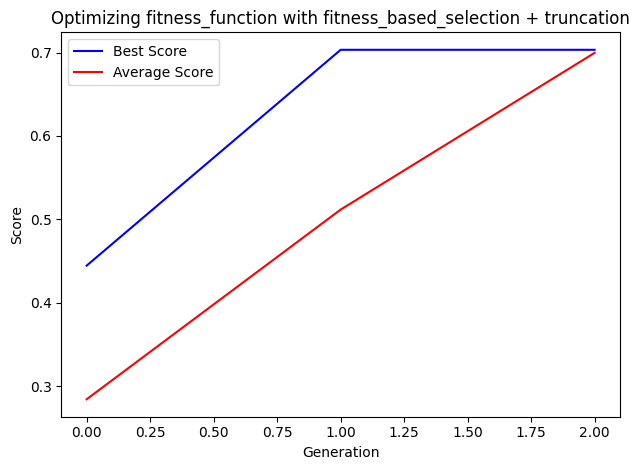

Generation: 2 with fitness_based_selection and truncation
1. Path = [0, 3, 2, 0, 0, 1, 1, 4, 4, 0], Score = 0.7033
2. Path = [0, 3, 2, 0, 0, 1, 1, 4, 4, 0], Score = 0.7033
3. Path = [0, 3, 2, 0, 0, 1, 1, 4, 4, 0], Score = 0.7033
4. Path = [0, 3, 2, 0, 0, 1, 1, 4, 4, 0], Score = 0.7033
5. Path = [0, 3, 2, 0, 0, 1, 1, 4, 4, 0], Score = 0.7033
6. Path = [0, 3, 2, 0, 0, 1, 1, 4, 4, 0], Score = 0.7033
7. Path = [0, 3, 2, 0, 0, 1, 1, 4, 4, 0], Score = 0.7033
8. Path = [0, 3, 2, 0, 0, 1, 1, 4, 4, 0], Score = 0.7033
9. Path = [0, 3, 2, 0, 0, 1, 1, 4, 4, 0], Score = 0.7033
10. Path = [0, 3, 1, 0, 2, 1, 1, 4, 4, 0], Score = 0.6667


('fitness_based_selection + truncation',
 [0.4444444444444444, 0.7032679738562092, 0.7032679738562092],
 [0.28418300653594775, 0.5116339869281046, 0.6996078431372549])

In [359]:
genetic_algorithm_n_gens(persons, fitness_function=fitness_function, n_gens=2)

Gen 0: 
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
Layer Type: GCNConv
Hidden Dimensions: [0, 128, 8, 64]
Activation Function: sigmoid
Pooling Function: global_max_pool
Learning Rate: 0.005
Batch Size: 8
Weight Decay: 1e-05
Epoch 0/20 => Test Loss: 2.2933, Test Accuracy: 0.0536
Epoch 10/20 => Train Loss: 1.9719, Train Accuracy: 0.3051 | Test Loss: 2.0371, Test Accuracy: 0.2131
Epoch 20/20 => Train Loss: 1.9454, Train Accuracy: 0.3175 | Test Loss: 2.0197, Test Accuracy: 0.2288
Layer Type: GATConv
Hidden Dimensions: [16, 32, 0, 4]
Activation Function: tanh
Pooling Function: global_add_pool
Learning Rate: 0.1
Batch Size: 128
Weight Decay: 1e-05
Epoch 0/20 => Test Loss: 58.2960, Test Accuracy: 0.0654
Epoch 10/20 => Train Loss: 64.5585, Train Accuracy: 0.4030 | Test Loss: 63.8445, Test Accuracy: 0.3542
Epoch 20/20 => Train Loss: 75.1761, Train Accuracy: 0.4181 | Test Loss: 72.1779, Test Accuracy: 0.3281
Layer Type: GCNConv
Hidden Dimensions: [8, 4, 0, 8]
Activation Function: sigmoid
Pooling Function: gl

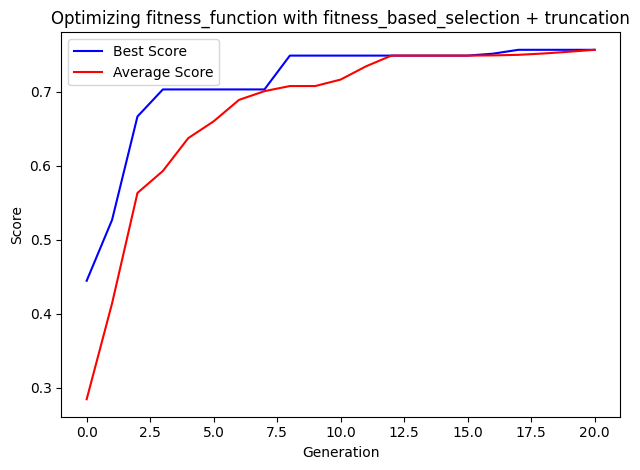

Generation: 20 with fitness_based_selection and truncation
1. Path = [0, 4, 3, 0, 0, 1, 1, 3, 4, 0], Score = 0.7569
2. Path = [0, 4, 3, 0, 0, 1, 1, 3, 4, 0], Score = 0.7569
3. Path = [0, 4, 3, 0, 0, 1, 1, 3, 4, 0], Score = 0.7569
4. Path = [0, 4, 3, 0, 0, 1, 1, 3, 4, 0], Score = 0.7569
5. Path = [0, 4, 3, 0, 0, 1, 1, 3, 4, 0], Score = 0.7569
6. Path = [0, 4, 3, 0, 0, 1, 1, 3, 4, 0], Score = 0.7569
7. Path = [0, 4, 3, 0, 0, 1, 1, 3, 4, 0], Score = 0.7569
8. Path = [0, 4, 3, 0, 0, 1, 1, 3, 4, 0], Score = 0.7569
9. Path = [0, 4, 3, 0, 0, 1, 1, 3, 4, 0], Score = 0.7569
10. Path = [0, 4, 3, 0, 0, 1, 1, 3, 4, 0], Score = 0.7569


('fitness_based_selection + truncation',
 [0.4444444444444444,
  0.526797385620915,
  0.6666666666666666,
  0.7032679738562092,
  0.7032679738562092,
  0.7032679738562092,
  0.7032679738562092,
  0.7032679738562092,
  0.7490196078431373,
  0.7490196078431373,
  0.7490196078431373,
  0.7490196078431373,
  0.7490196078431373,
  0.7490196078431373,
  0.7490196078431373,
  0.7490196078431373,
  0.7516339869281046,
  0.7568627450980392,
  0.7568627450980392,
  0.7568627450980392,
  0.7568627450980392],
 [0.28418300653594775,
  0.41385620915032684,
  0.5632679738562092,
  0.5929411764705883,
  0.6373856209150327,
  0.6601307189542484,
  0.6891503267973856,
  0.7009150326797385,
  0.707843137254902,
  0.707843137254902,
  0.7166013071895425,
  0.7345098039215687,
  0.7490196078431373,
  0.7490196078431373,
  0.7490196078431373,
  0.7490196078431373,
  0.749281045751634,
  0.7500653594771242,
  0.7518954248366013,
  0.7542483660130719,
  0.7568627450980392])

In [361]:
genetic_algorithm_n_gens(persons, fitness_function=fitness_function, n_gens=20)

Gen 0: 
Layer Type: GATConv
Hidden Dimensions: [8, 8, 0, 4]
Activation Function: sigmoid
Pooling Function: global_add_pool
Learning Rate: 0.005
Batch Size: 128
Weight Decay: 0.001
Epoch 0/20 => Test Loss: 108.9927, Test Accuracy: 0.1085
Epoch 10/20 => Train Loss: 4.0764, Train Accuracy: 0.2831 | Test Loss: 4.8315, Test Accuracy: 0.2536
Epoch 20/20 => Train Loss: 2.6375, Train Accuracy: 0.4339 | Test Loss: 3.4582, Test Accuracy: 0.2771
Layer Type: GCNConv
Hidden Dimensions: [4, 4, 4, 32]
Activation Function: sigmoid
Pooling Function: global_add_pool
Learning Rate: 0.01
Batch Size: 16
Weight Decay: 1e-05
Epoch 0/20 => Test Loss: 85.4041, Test Accuracy: 0.1020
Epoch 10/20 => Train Loss: 6.1450, Train Accuracy: 0.2073 | Test Loss: 5.8854, Test Accuracy: 0.1935
Epoch 20/20 => Train Loss: 3.7793, Train Accuracy: 0.2837 | Test Loss: 5.4817, Test Accuracy: 0.2484
Layer Type: GCNConv
Hidden Dimensions: [8, 8, 4, 0]
Activation Function: relu
Pooling Function: global_max_pool
Learning Rate: 0.01


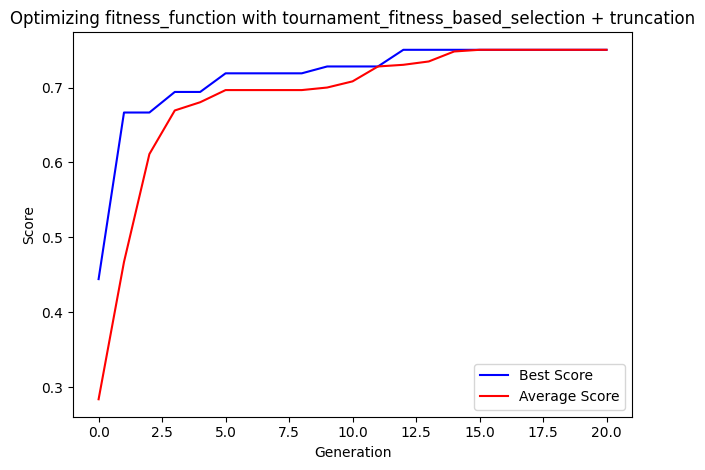

Generation: 20 with tournament_fitness_based_selection and truncation
1. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
2. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
3. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
4. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
5. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
6. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
7. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
8. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
9. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503
10. Path = [0, 4, 0, 0, 1, 1, 1, 4, 4, 0], Score = 0.7503


('tournament_fitness_based_selection + truncation',
 [0.4444444444444444,
  0.6666666666666666,
  0.6666666666666666,
  0.6941176470588235,
  0.6941176470588235,
  0.7189542483660131,
  0.7189542483660131,
  0.7189542483660131,
  0.7189542483660131,
  0.7281045751633987,
  0.7281045751633987,
  0.7281045751633987,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209],
 [0.28418300653594775,
  0.4673202614379085,
  0.6112418300653595,
  0.6694117647058823,
  0.6803921568627451,
  0.6966013071895425,
  0.6966013071895425,
  0.6966013071895425,
  0.6966013071895425,
  0.7,
  0.7082352941176471,
  0.7281045751633987,
  0.7303267973856209,
  0.7347712418300654,
  0.7481045751633987,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209])

In [362]:
genetic_algorithm_n_gens(persons, fitness_function=fitness_function, n_gens=20, parent_selection_function=tournament_fitness_based_selection)

In [364]:
Memo = {(1, 2, 3, 6, 4, 0, 1, 3, 4, 0): 0.38562091503267976,
 (1, 4, 4, 1, 1, 2, 0, 4, 2, 0): 0.12418300653594772,
 (0, 0, 2, 5, 6, 1, 0, 0, 3, 2): 0.25359477124183005,
 (1, 1, 2, 1, 1, 2, 0, 2, 5, 0): 0.14640522875816994,
 (0, 2, 5, 1, 4, 0, 2, 2, 5, 0): 0.09411764705882353,
 (0, 0, 1, 3, 2, 0, 1, 1, 4, 2): 0.3895424836601307,
 (0, 2, 1, 0, 4, 2, 0, 1, 2, 2): 0.3241830065359477,
 (1, 0, 4, 2, 1, 2, 0, 2, 5, 0): 0.2954248366013072,
 (0, 3, 6, 0, 5, 1, 2, 4, 0, 0): 0.4444444444444444,
 (0, 0, 2, 2, 0, 0, 1, 2, 4, 0): 0.3843137254901961,
 (0, 0, 6, 3, 5, 0, 2, 1, 0, 2): 0.2823529411764706,
 (0, 3, 1, 0, 2, 1, 1, 4, 4, 0): 0.6666666666666666,
 (0, 3, 2, 0, 6, 1, 0, 4, 3, 0): 0.33464052287581697,
 (0, 0, 6, 5, 5, 1, 2, 0, 0, 2): 0.3045751633986928,
 (0, 3, 2, 0, 0, 1, 1, 4, 4, 0): 0.7032679738562092,
 (0, 0, 6, 2, 5, 0, 2, 2, 0, 0): 0.19477124183006536,
 (0, 3, 1, 0, 4, 1, 0, 4, 2, 0): 0.2065359477124183,
 (0, 2, 6, 0, 5, 2, 2, 1, 0, 2): 0.6535947712418301,
 (0, 0, 2, 5, 0, 1, 1, 0, 4, 2): 0.38562091503267976,
 (0, 0, 2, 2, 6, 0, 0, 2, 3, 0): 0.25620915032679736,
 (1, 0, 3, 3, 4, 0, 1, 1, 4, 2): 0.4,
 (0, 2, 1, 6, 2, 0, 1, 3, 4, 0): 0.3137254901960784,
 (0, 0, 6, 2, 5, 1, 2, 2, 0, 0): 0.34901960784313724,
 (1, 0, 3, 2, 4, 0, 1, 2, 4, 0): 0.3202614379084967,
 (0, 2, 2, 6, 0, 0, 1, 3, 4, 0): 0.09411764705882353,
 (1, 0, 2, 2, 1, 2, 0, 2, 5, 0): 0.35947712418300654,
 (1, 1, 4, 1, 1, 1, 0, 2, 5, 0): 0.2679738562091503,
 (0, 1, 6, 1, 5, 2, 2, 2, 0, 0): 0.33725490196078434,
 (1, 3, 2, 0, 1, 1, 0, 4, 5, 0): 0.2169934640522876,
 (0, 2, 2, 0, 0, 2, 1, 1, 4, 2): 0.44575163398692813,
 (1, 3, 3, 0, 4, 2, 1, 4, 4, 0): 0.6418300653594772,
 (0, 0, 6, 2, 5, 2, 2, 1, 1, 0): 0.22875816993464052,
 (1, 3, 4, 0, 1, 1, 0, 4, 5, 0): 0.3281045751633987,
 (0, 2, 1, 0, 2, 2, 1, 1, 4, 2): 0.3843137254901961,
 (0, 0, 0, 3, 4, 0, 0, 1, 2, 2): 0.13725490196078433,
 (0, 2, 5, 6, 4, 0, 2, 3, 5, 0): 0.2679738562091503,
 (1, 2, 3, 1, 4, 0, 1, 2, 4, 2): 0.5215686274509804,
 (1, 2, 2, 6, 1, 0, 0, 3, 5, 0): 0.10196078431372549,
 (1, 1, 3, 1, 4, 2, 1, 2, 4, 0): 0.3712418300653595,
 (1, 3, 4, 0, 1, 1, 0, 4, 2, 0): 0.29411764705882354,
 (0, 4, 5, 2, 5, 2, 2, 4, 0, 0): 0.17777777777777778,
 (0, 0, 1, 5, 2, 1, 1, 0, 4, 2): 0.33986928104575165,
 (0, 0, 2, 3, 6, 0, 0, 1, 3, 2): 0.2196078431372549,
 (1, 1, 4, 5, 1, 1, 0, 0, 5, 2): 0.1895424836601307,
 (0, 0, 2, 2, 6, 2, 0, 2, 3, 0): 0.2823529411764706,
 (0, 0, 5, 2, 4, 0, 2, 2, 5, 0): 0.34509803921568627,
 (1, 2, 2, 1, 0, 0, 1, 2, 4, 0): 0.526797385620915,
 (1, 3, 3, 0, 4, 1, 1, 4, 4, 0): 0.4797385620915033,
 (1, 2, 3, 1, 4, 0, 1, 2, 4, 0): 0.5790849673202615,
 (1, 2, 2, 1, 0, 0, 1, 2, 4, 2): 0.45359477124183006,
 (0, 0, 1, 2, 2, 0, 1, 2, 4, 0): 0.24313725490196078,
 (0, 2, 2, 1, 0, 0, 1, 2, 4, 2): 0.5215686274509804,
 (0, 1, 3, 1, 4, 2, 1, 2, 4, 0): 0.35947712418300654,
 (0, 3, 1, 1, 2, 1, 1, 4, 4, 0): 0.5411764705882353,
 (0, 0, 6, 3, 5, 0, 0, 1, 0, 0): 0.25098039215686274,
 (0, 2, 6, 1, 5, 0, 2, 2, 0, 2): 0.09411764705882353,
 (1, 2, 2, 6, 0, 0, 1, 3, 4, 0): 0.45098039215686275,
 (0, 2, 1, 1, 2, 0, 1, 2, 4, 0): 0.46013071895424834,
 (1, 3, 3, 1, 4, 1, 1, 4, 4, 0): 0.35555555555555557,
 (0, 2, 1, 1, 2, 0, 1, 2, 4, 2): 0.46797385620915033,
 (0, 2, 1, 0, 1, 2, 1, 1, 4, 2): 0.37777777777777777,
 (1, 2, 3, 1, 4, 0, 1, 2, 3, 0): 0.46013071895424834,
 (1, 3, 2, 0, 4, 1, 1, 4, 4, 0): 0.6326797385620915,
 (0, 2, 2, 1, 0, 0, 1, 2, 4, 0): 0.6261437908496732,
 (1, 3, 2, 0, 6, 1, 1, 4, 4, 0): 0.5686274509803921,
 (1, 2, 3, 1, 4, 1, 1, 2, 4, 2): 0.6797385620915033,
 (1, 2, 3, 1, 3, 0, 1, 2, 4, 0): 0.5986928104575163,
 (1, 3, 3, 1, 4, 1, 1, 4, 4, 2): 0.39738562091503266,
 (1, 3, 3, 0, 4, 1, 1, 4, 5, 0): 0.6078431372549019,
 (1, 2, 3, 1, 3, 1, 1, 2, 4, 2): 0.6705882352941176,
 (1, 2, 3, 1, 4, 1, 1, 2, 5, 2): 0.6052287581699346,
 (0, 2, 6, 1, 5, 0, 2, 2, 0, 0): 0.09411764705882353,
 (1, 3, 3, 0, 4, 1, 0, 4, 5, 0): 0.3241830065359477,
 (1, 2, 3, 0, 3, 2, 1, 1, 4, 2): 0.5830065359477125,
 (1, 2, 6, 1, 5, 0, 2, 2, 0, 2): 0.09411764705882353,
 (1, 3, 2, 0, 5, 1, 1, 4, 4, 0): 0.5176470588235295,
 (1, 3, 2, 0, 4, 1, 1, 4, 5, 0): 0.4849673202614379,
 (0, 2, 6, 1, 5, 1, 2, 2, 0, 2): 0.46013071895424834,
 (1, 2, 3, 0, 4, 2, 1, 1, 4, 2): 0.6143790849673203,
 (0, 2, 2, 1, 0, 1, 1, 2, 4, 2): 0.6379084967320261,
 (0, 3, 1, 0, 1, 1, 1, 4, 4, 0): 0.6941176470588235,
 (1, 2, 2, 1, 4, 1, 1, 2, 4, 2): 0.6196078431372549,
 (1, 3, 3, 0, 3, 1, 1, 4, 4, 0): 0.6209150326797386,
 (0, 3, 2, 0, 0, 1, 1, 3, 4, 0): 0.6836601307189543,
 (1, 3, 3, 0, 4, 0, 1, 3, 4, 0): 0.5712418300653594,
 (0, 3, 2, 0, 0, 1, 1, 4, 3, 0): 0.6366013071895424,
 (1, 4, 3, 1, 3, 1, 1, 4, 4, 0): 0.4235294117647059,
 (0, 3, 1, 1, 1, 1, 1, 2, 4, 2): 0.6392156862745098,
 (0, 3, 3, 0, 3, 1, 1, 4, 4, 0): 0.6980392156862745,
 (1, 3, 3, 0, 3, 1, 1, 3, 4, 0): 0.6444444444444445,
 (0, 3, 2, 1, 0, 1, 1, 4, 4, 0): 0.6496732026143791,
 (0, 3, 3, 0, 3, 1, 0, 4, 4, 0): 0.38300653594771245,
 (0, 4, 2, 0, 0, 1, 1, 3, 4, 0): 0.7490196078431373,
 (0, 3, 1, 0, 1, 1, 0, 4, 4, 0): 0.2549019607843137,
 (0, 3, 2, 0, 2, 1, 1, 4, 4, 0): 0.6915032679738562,
 (0, 3, 2, 0, 6, 1, 1, 4, 4, 0): 0.6679738562091503,
 (0, 3, 2, 0, 0, 2, 1, 4, 4, 0): 0.6954248366013072,
 (0, 3, 2, 0, 0, 1, 1, 4, 5, 0): 0.6993464052287581,
 (0, 4, 2, 0, 0, 1, 1, 2, 4, 0): 0.7450980392156863,
 (0, 3, 2, 0, 0, 1, 1, 0, 4, 0): 0.49019607843137253,
 (0, 3, 2, 0, 0, 1, 1, 0, 3, 0): 0.615686274509804,
 (0, 3, 2, 0, 0, 1, 1, 4, 4, 2): 0.6888888888888889,
 (0, 3, 2, 0, 0, 1, 2, 4, 4, 0): 0.5202614379084968,
 (0, 3, 2, 0, 0, 1, 1, 4, 4, 1): 0.6967320261437908,
 (0, 2, 2, 0, 0, 1, 1, 4, 4, 0): 0.6888888888888889,
 (0, 3, 2, 0, 1, 1, 1, 4, 4, 0): 0.681045751633987,
 (0, 3, 2, 0, 0, 1, 0, 4, 4, 0): 0.3790849673202614,
 (1, 4, 2, 0, 0, 1, 1, 3, 5, 2): 0.6745098039215687,
 (1, 3, 2, 0, 0, 1, 1, 4, 4, 0): 0.5594771241830065,
 (0, 4, 2, 0, 0, 1, 2, 2, 4, 0): 0.6705882352941176,
 (1, 4, 2, 0, 0, 1, 1, 3, 4, 0): 0.5934640522875817,
 (0, 4, 2, 0, 6, 1, 1, 2, 4, 0): 0.7215686274509804,
 (0, 4, 1, 0, 0, 1, 1, 3, 4, 0): 0.7006535947712418,
 (0, 5, 2, 0, 1, 0, 1, 3, 4, 1): 0.09411764705882353,
 (0, 4, 2, 0, 0, 2, 1, 3, 4, 0): 0.7084967320261438,
 (0, 4, 2, 0, 0, 1, 2, 3, 5, 0): 0.6248366013071895,
 (0, 4, 2, 0, 0, 1, 1, 3, 5, 0): 0.7477124183006536,
 (0, 4, 2, 0, 0, 1, 2, 3, 4, 2): 0.5908496732026144,
 (0, 4, 2, 1, 0, 1, 1, 3, 4, 0): 0.6496732026143791,
 (0, 4, 2, 0, 0, 1, 0, 3, 4, 0): 0.396078431372549,
 (0, 4, 2, 0, 0, 0, 1, 3, 4, 0): 0.09411764705882353,
 (0, 4, 2, 0, 0, 1, 2, 3, 4, 0): 0.5895424836601307,
 (0, 4, 2, 0, 0, 1, 1, 3, 4, 2): 0.7176470588235294,
 (0, 4, 2, 0, 1, 1, 1, 3, 4, 0): 0.6875816993464052,
 (0, 4, 2, 0, 6, 1, 1, 3, 4, 0): 0.7516339869281046,
 (0, 4, 2, 0, 0, 1, 1, 4, 4, 0): 0.6875816993464052,
 (0, 4, 2, 0, 6, 1, 1, 3, 5, 0): 0.7176470588235294,
 (0, 5, 2, 0, 0, 1, 1, 3, 4, 0): 0.7320261437908496,
 (0, 4, 2, 0, 0, 1, 1, 4, 4, 2): 0.6562091503267974,
 (0, 4, 3, 0, 0, 1, 1, 3, 4, 0): 0.7568627450980392,
 (1, 4, 2, 0, 0, 1, 1, 2, 4, 0): 0.74640522875817,
 (1, 5, 3, 0, 0, 1, 1, 3, 4, 0): 0.6366013071895424,
 (0, 4, 3, 0, 0, 1, 1, 4, 4, 0): 0.7124183006535948,
 (0, 4, 3, 0, 0, 1, 1, 3, 4, 2): 0.7359477124183007,
 (0, 4, 3, 0, 0, 1, 1, 3, 3, 0): 0.7084967320261438,
 (0, 4, 3, 0, 0, 1, 0, 3, 5, 0): 0.41830065359477125,
 (0, 5, 2, 0, 6, 1, 1, 3, 4, 0): 0.7084967320261438,
 (1, 2, 2, 0, 1, 2, 0, 1, 5, 2): 0.27712418300653596,
 (0, 1, 1, 1, 4, 2, 0, 2, 2, 0): 0.24836601307189543,
 (0, 2, 2, 1, 0, 0, 2, 2, 4, 0): 0.2954248366013072,
 (0, 0, 5, 2, 4, 0, 0, 2, 5, 0): 0.24052287581699347,
 (0, 3, 6, 0, 5, 1, 0, 4, 0, 0): 0.28888888888888886,
 (1, 2, 4, 6, 1, 0, 0, 3, 5, 0): 0.1111111111111111,
 (1, 0, 3, 2, 4, 1, 1, 1, 4, 0): 0.5071895424836601,
 (1, 2, 3, 0, 1, 2, 0, 1, 5, 2): 0.19607843137254902,
 (1, 2, 3, 6, 5, 0, 1, 3, 4, 2): 0.23790849673202613,
 (0, 3, 1, 0, 2, 1, 2, 4, 4, 0): 0.538562091503268,
 (0, 3, 6, 0, 6, 1, 2, 4, 0, 0): 0.42091503267973857,
 (0, 2, 2, 6, 6, 0, 1, 4, 4, 0): 0.09411764705882353,
 (0, 0, 1, 2, 2, 1, 1, 1, 4, 0): 0.45751633986928103,
 (1, 3, 1, 0, 2, 1, 1, 4, 4, 0): 0.5895424836601307,
 (0, 2, 1, 0, 1, 1, 1, 4, 4, 0): 0.6431372549019608,
 (0, 3, 1, 1, 1, 1, 1, 0, 4, 0): 0.2928104575163399,
 (1, 3, 1, 0, 1, 1, 1, 4, 4, 0): 0.5228758169934641,
 (0, 3, 0, 6, 2, 1, 1, 4, 4, 0): 0.7189542483660131,
 (0, 3, 1, 0, 1, 1, 1, 4, 3, 2): 0.6549019607843137,
 (0, 3, 1, 0, 0, 1, 1, 4, 4, 0): 0.6222222222222222,
 (0, 3, 1, 6, 1, 1, 1, 4, 4, 0): 0.5843137254901961,
 (0, 3, 0, 0, 2, 1, 1, 4, 4, 0): 0.6849673202614379,
 (0, 3, 1, 6, 1, 1, 1, 3, 4, 0): 0.6797385620915033,
 (0, 3, 1, 0, 0, 1, 1, 3, 4, 0): 0.6549019607843137,
 (0, 3, 1, 0, 1, 2, 1, 4, 4, 0): 0.6875816993464052,
 (0, 2, 1, 0, 0, 1, 1, 4, 4, 0): 0.6470588235294118,
 (0, 3, 0, 0, 2, 1, 1, 0, 4, 0): 0.5228758169934641,
 (0, 3, 0, 0, 1, 1, 1, 4, 4, 0): 0.7281045751633987,
 (0, 3, 1, 1, 1, 1, 1, 3, 4, 0): 0.6222222222222222,
 (0, 2, 1, 0, 1, 1, 1, 4, 5, 0): 0.6418300653594772,
 (0, 3, 1, 1, 1, 1, 0, 4, 4, 0): 0.24052287581699347,
 (0, 3, 0, 0, 1, 1, 1, 3, 4, 0): 0.7084967320261438,
 (0, 3, 1, 0, 1, 1, 1, 3, 4, 0): 0.673202614379085,
 (0, 3, 0, 0, 1, 2, 1, 4, 4, 0): 0.7111111111111111,
 (0, 3, 1, 0, 1, 1, 1, 4, 4, 1): 0.6366013071895424,
 (1, 3, 1, 0, 1, 1, 1, 3, 4, 0): 0.6588235294117647,
 (0, 3, 0, 5, 1, 1, 1, 4, 4, 0): 0.6758169934640523,
 (0, 2, 0, 0, 1, 1, 1, 4, 4, 0): 0.6588235294117647,
 (0, 3, 0, 0, 1, 1, 1, 4, 5, 0): 0.6967320261437908,
 (0, 3, 1, 1, 1, 1, 1, 4, 4, 0): 0.5620915032679739,
 (0, 4, 0, 0, 1, 1, 1, 4, 4, 0): 0.7503267973856209,
 (0, 3, 0, 0, 0, 1, 1, 4, 4, 0): 0.7163398692810458,
 (0, 3, 0, 0, 1, 1, 1, 4, 4, 1): 0.6967320261437908,
 (1, 3, 0, 0, 2, 1, 1, 4, 4, 0): 0.4954248366013072,
 (0, 4, 1, 0, 1, 1, 1, 4, 4, 0): 0.6235294117647059,
 (0, 4, 0, 0, 1, 1, 2, 4, 5, 0): 0.6418300653594772,
 (0, 4, 0, 6, 1, 1, 1, 4, 4, 0): 0.7137254901960784,
 (0, 5, 0, 0, 1, 1, 1, 4, 3, 0): 0.6549019607843137,
 (0, 4, 0, 0, 1, 1, 2, 4, 4, 0): 0.534640522875817,
 (0, 4, 0, 1, 1, 1, 1, 4, 4, 0): 0.7254901960784313,
 (0, 4, 0, 0, 1, 1, 1, 4, 4, 2): 0.730718954248366,
 (0, 4, 0, 0, 1, 1, 1, 3, 4, 0): 0.74640522875817,
 (0, 4, 1, 6, 1, 1, 1, 4, 4, 0): 0.6078431372549019,
 (0, 5, 0, 0, 1, 1, 1, 4, 4, 0): 0.7320261437908496,
 (1, 4, 0, 0, 1, 1, 1, 4, 4, 0): 0.6888888888888889,
 (0, 4, 0, 0, 1, 0, 1, 4, 4, 0): 0.29673202614379085,
 (0, 4, 0, 0, 0, 1, 1, 4, 4, 0): 0.7294117647058823,
 (0, 4, 0, 0, 1, 1, 1, 4, 5, 0): 0.7411764705882353,
 (0, 4, 0, 0, 1, 1, 0, 4, 4, 0): 0.5098039215686274,
 (0, 4, 6, 0, 1, 1, 0, 4, 4, 0): 0.4261437908496732}

In [367]:

fitness_function([0, 4, 0, 0, 1, 1, 1, 4, 4, 0], epochs = 10)

Layer Type: GCNConv
Hidden Dimensions: [32, 0, 0, 4]
Activation Function: tanh
Pooling Function: global_mean_pool
Learning Rate: 0.1
Batch Size: 64
Weight Decay: 1e-05


c:\Users\Adeel\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0/100 => Test Loss: 2.3377, Test Accuracy: 0.1098
Epoch 10/100 => Train Loss: 0.7539, Train Accuracy: 0.7583 | Test Loss: 0.9241, Test Accuracy: 0.6967
Epoch 20/100 => Train Loss: 0.6821, Train Accuracy: 0.7848 | Test Loss: 0.8457, Test Accuracy: 0.6941
Epoch 30/100 => Train Loss: 0.6689, Train Accuracy: 0.7835 | Test Loss: 0.9094, Test Accuracy: 0.7137
Epoch 40/100 => Train Loss: 0.6420, Train Accuracy: 0.7933 | Test Loss: 0.8696, Test Accuracy: 0.7190
Epoch 50/100 => Train Loss: 0.5953, Train Accuracy: 0.8081 | Test Loss: 0.8676, Test Accuracy: 0.7346
Epoch 60/100 => Train Loss: 0.5972, Train Accuracy: 0.8100 | Test Loss: 0.8749, Test Accuracy: 0.7503
Epoch 70/100 => Train Loss: 0.5739, Train Accuracy: 0.8072 | Test Loss: 0.8897, Test Accuracy: 0.7346
Epoch 80/100 => Train Loss: 0.5844, Train Accuracy: 0.8094 | Test Loss: 0.9533, Test Accuracy: 0.7033
Epoch 90/100 => Train Loss: 0.5146, Train Accuracy: 0.8309 | Test Loss: 0.8900, Test Accuracy: 0.7464
Epoch 100/100 => Train Los

0.7594771241830065

Layer Type: GATConv
Hidden Dimensions: [8, 16, 128, 32]
Activation Function: relu
Pooling Function: global_mean_pool
Learning Rate: 0.05
Batch Size: 64
Weight Decay: 1e-05


c:\Users\Adeel\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0/20 => Test Loss: 3.5890, Test Accuracy: 0.0863
Epoch 10/20 => Train Loss: 1.6278, Train Accuracy: 0.4017 | Test Loss: 1.7600, Test Accuracy: 0.3529
Epoch 20/20 => Train Loss: 1.5897, Train Accuracy: 0.4222 | Test Loss: 1.7588, Test Accuracy: 0.3438
Layer Type: GATConv
Hidden Dimensions: [32, 32, 4, 4]
Activation Function: sigmoid
Pooling Function: global_add_pool
Learning Rate: 0.1
Batch Size: 16
Weight Decay: 1e-05
Epoch 0/20 => Test Loss: 100.2208, Test Accuracy: 0.0549
Epoch 10/20 => Train Loss: 27.4891, Train Accuracy: 0.1319 | Test Loss: 44.4711, Test Accuracy: 0.0941
Epoch 20/20 => Train Loss: 24.4951, Train Accuracy: 0.1303 | Test Loss: 51.1555, Test Accuracy: 0.1020
Layer Type: GCNConv
Hidden Dimensions: [0, 8, 64, 128]
Activation Function: tanh
Pooling Function: global_add_pool
Learning Rate: 0.001
Batch Size: 32
Weight Decay: 0.001
Epoch 0/20 => Test Loss: 91.5610, Test Accuracy: 0.0706
Epoch 10/20 => Train Loss: 46.6178, Train Accuracy: 0.2679 | Test Loss: 54.5953, T

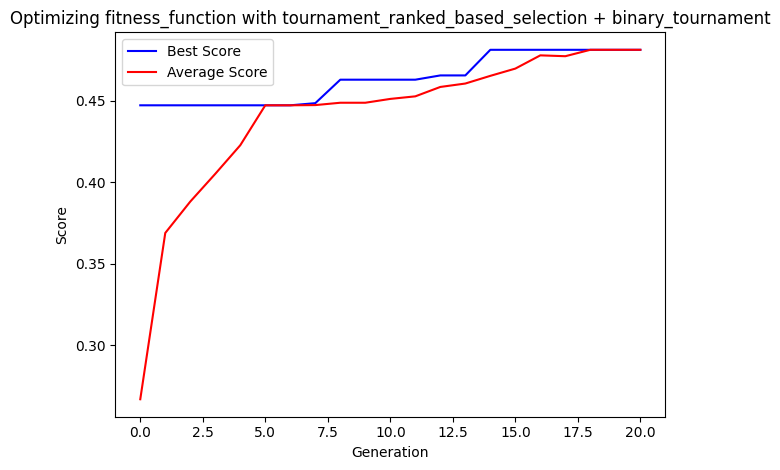

Generation: 20 with tournament_ranked_based_selection and binary_tournament
1. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
2. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
3. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
4. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
5. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
6. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
7. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
8. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
9. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810
10. Path = [0, 0, 2, 3, 0, 0, 1, 2, 4, 2], Score = 0.4810


('tournament_ranked_based_selection + binary_tournament',
 [0.4470588235294118,
  0.4470588235294118,
  0.4470588235294118,
  0.4470588235294118,
  0.4470588235294118,
  0.4470588235294118,
  0.4470588235294118,
  0.44836601307189544,
  0.4627450980392157,
  0.4627450980392157,
  0.4627450980392157,
  0.4627450980392157,
  0.465359477124183,
  0.465359477124183,
  0.48104575163398694,
  0.48104575163398694,
  0.48104575163398694,
  0.48104575163398694,
  0.48104575163398694,
  0.48104575163398694,
  0.48104575163398694],
 [0.26705882352941174,
  0.36888888888888893,
  0.3881045751633987,
  0.40509803921568627,
  0.42261437908496735,
  0.4470588235294118,
  0.4470588235294118,
  0.44718954248366016,
  0.44862745098039214,
  0.44862745098039214,
  0.45098039215686275,
  0.4525490196078431,
  0.4583006535947713,
  0.46039215686274515,
  0.4650980392156863,
  0.46954248366013074,
  0.4776470588235294,
  0.4771241830065359,
  0.4810457516339869,
  0.4810457516339869,
  0.4810457516339869])

In [368]:
Memo = {}
genetic_algorithm_n_gens(persons, fitness_function=fitness_function, n_gens=20, parent_selection_function=tournament_ranked_based_selection, survival_function=binary_tournament)

Gen 0: 
Layer Type: GCNConv
Hidden Dimensions: [0, 8, 8, 0]
Activation Function: relu
Pooling Function: global_mean_pool
Learning Rate: 0.01
Batch Size: 32
Weight Decay: 1e-05
Epoch 0/20 => Test Loss: 6.5918, Test Accuracy: 0.1229
Epoch 10/20 => Train Loss: 2.0646, Train Accuracy: 0.4096 | Test Loss: 2.5014, Test Accuracy: 0.2889
Epoch 20/20 => Train Loss: 1.8660, Train Accuracy: 0.4894 | Test Loss: 2.1388, Test Accuracy: 0.3739
Layer Type: GATConv
Hidden Dimensions: [0, 32, 16, 4]
Activation Function: sigmoid
Pooling Function: global_add_pool
Learning Rate: 0.01
Batch Size: 128
Weight Decay: 1e-05
Epoch 0/20 => Test Loss: 27.6028, Test Accuracy: 0.1386
Epoch 10/20 => Train Loss: 6.2858, Train Accuracy: 0.3626 | Test Loss: 8.7522, Test Accuracy: 0.3059
Epoch 20/20 => Train Loss: 2.3302, Train Accuracy: 0.4339 | Test Loss: 2.6535, Test Accuracy: 0.3242
Layer Type: GATConv
Hidden Dimensions: [0, 16, 8, 4]
Activation Function: sigmoid
Pooling Function: global_add_pool
Learning Rate: 0.01


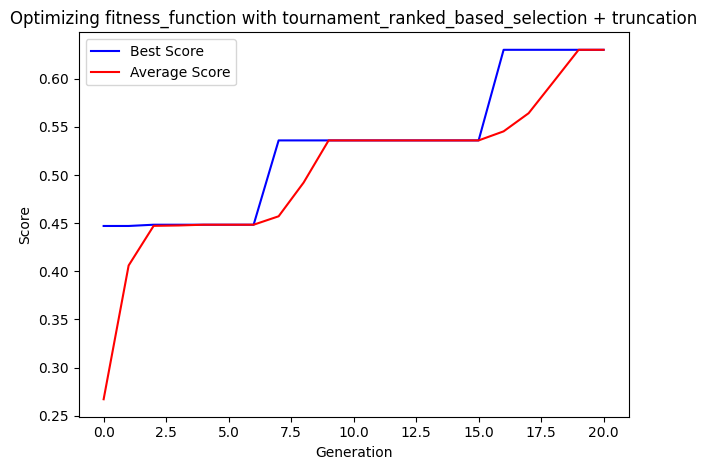

Generation: 20 with tournament_ranked_based_selection and truncation
1. Path = [1, 2, 1, 2, 6, 0, 1, 2, 4, 0], Score = 0.6301
2. Path = [1, 2, 1, 2, 6, 0, 1, 2, 4, 0], Score = 0.6301
3. Path = [1, 2, 1, 2, 6, 0, 1, 2, 4, 0], Score = 0.6301
4. Path = [1, 2, 1, 2, 6, 0, 1, 2, 4, 0], Score = 0.6301
5. Path = [1, 2, 1, 2, 6, 0, 1, 2, 4, 0], Score = 0.6301
6. Path = [1, 2, 1, 2, 6, 0, 1, 2, 4, 0], Score = 0.6301
7. Path = [1, 2, 1, 2, 6, 0, 1, 2, 4, 0], Score = 0.6301
8. Path = [1, 2, 1, 2, 6, 0, 1, 2, 4, 0], Score = 0.6301
9. Path = [1, 2, 1, 2, 6, 0, 1, 2, 4, 0], Score = 0.6301
10. Path = [1, 2, 1, 2, 6, 0, 1, 2, 4, 0], Score = 0.6301


('tournament_ranked_based_selection + truncation',
 [0.4470588235294118,
  0.4470588235294118,
  0.44836601307189544,
  0.44836601307189544,
  0.44836601307189544,
  0.44836601307189544,
  0.44836601307189544,
  0.5359477124183006,
  0.5359477124183006,
  0.5359477124183006,
  0.5359477124183006,
  0.5359477124183006,
  0.5359477124183006,
  0.5359477124183006,
  0.5359477124183006,
  0.5359477124183006,
  0.6300653594771242,
  0.6300653594771242,
  0.6300653594771242,
  0.6300653594771242,
  0.6300653594771242],
 [0.26705882352941174,
  0.4060130718954248,
  0.44718954248366016,
  0.44758169934640524,
  0.44836601307189544,
  0.44836601307189544,
  0.44836601307189544,
  0.4571241830065359,
  0.49215686274509807,
  0.5359477124183006,
  0.5359477124183006,
  0.5359477124183006,
  0.5359477124183006,
  0.5359477124183006,
  0.5359477124183006,
  0.5359477124183006,
  0.545359477124183,
  0.5641830065359477,
  0.5969934640522876,
  0.6300653594771242,
  0.6300653594771242])

In [369]:
genetic_algorithm_n_gens(persons, fitness_function=fitness_function, n_gens=20, parent_selection_function=tournament_ranked_based_selection)

In [370]:
Memo

{(1, 2, 3, 6, 4, 0, 1, 3, 4, 0): 0.3437908496732026,
 (1, 4, 4, 1, 1, 2, 0, 4, 2, 0): 0.10196078431372549,
 (0, 0, 2, 5, 6, 1, 0, 0, 3, 2): 0.19738562091503267,
 (1, 1, 2, 1, 1, 2, 0, 2, 5, 0): 0.25098039215686274,
 (0, 2, 5, 1, 4, 0, 2, 2, 5, 0): 0.09411764705882353,
 (0, 0, 1, 3, 2, 0, 1, 1, 4, 2): 0.36209150326797385,
 (0, 2, 1, 0, 4, 2, 0, 1, 2, 2): 0.3032679738562091,
 (1, 0, 4, 2, 1, 2, 0, 2, 5, 0): 0.22875816993464052,
 (0, 3, 6, 0, 5, 1, 2, 4, 0, 0): 0.3411764705882353,
 (0, 0, 2, 2, 0, 0, 1, 2, 4, 0): 0.4470588235294118,
 (0, 2, 1, 0, 4, 2, 0, 1, 1, 2): 0.3673202614379085,
 (0, 2, 1, 6, 4, 2, 0, 1, 2, 2): 0.054901960784313725,
 (0, 0, 2, 2, 0, 2, 1, 2, 4, 0): 0.38823529411764707,
 (0, 0, 2, 2, 0, 0, 1, 1, 4, 0): 0.2928104575163399,
 (0, 0, 2, 2, 6, 0, 1, 2, 4, 0): 0.44836601307189544,
 (0, 0, 2, 2, 0, 0, 2, 2, 4, 0): 0.41830065359477125,
 (0, 0, 2, 2, 0, 1, 1, 2, 4, 0): 0.4261437908496732,
 (0, 0, 2, 3, 0, 0, 1, 2, 4, 0): 0.4627450980392157,
 (0, 0, 3, 2, 0, 0, 1, 2, 4, 0): 0.

Gen 0: 
Layer Type: GCNConv
Hidden Dimensions: [0, 4, 8, 8]
Activation Function: relu
Pooling Function: global_mean_pool
Learning Rate: 0.01
Batch Size: 64
Weight Decay: 1e-05
Epoch 0/20 => Test Loss: 6.8636, Test Accuracy: 0.2065
Epoch 10/20 => Train Loss: 2.8221, Train Accuracy: 0.5207 | Test Loss: 3.5898, Test Accuracy: 0.4562
Epoch 20/20 => Train Loss: 2.4871, Train Accuracy: 0.5222 | Test Loss: 3.2053, Test Accuracy: 0.4510
Layer Type: GCNConv
Hidden Dimensions: [4, 8, 16, 0]
Activation Function: relu
Pooling Function: global_mean_pool
Learning Rate: 0.005
Batch Size: 64
Weight Decay: 0.001
Epoch 0/20 => Test Loss: 6.7008, Test Accuracy: 0.0392
Epoch 10/20 => Train Loss: 1.6380, Train Accuracy: 0.4680 | Test Loss: 1.7089, Test Accuracy: 0.3569
Epoch 20/20 => Train Loss: 1.4875, Train Accuracy: 0.5803 | Test Loss: 1.5262, Test Accuracy: 0.4627
Layer Type: GATConv
Hidden Dimensions: [8, 16, 0, 32]
Activation Function: sigmoid
Pooling Function: global_mean_pool
Learning Rate: 0.005
B

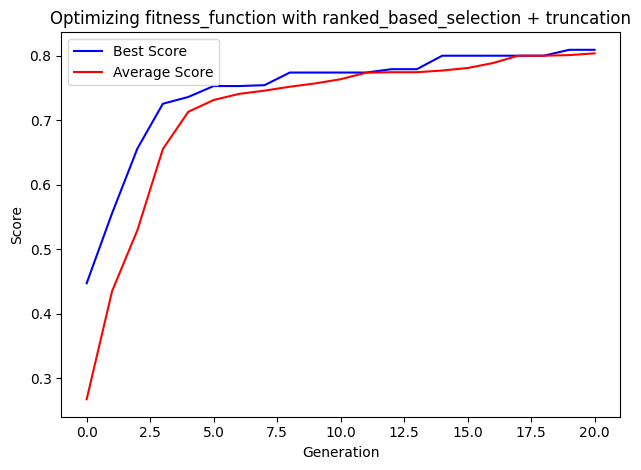

Generation: 20 with ranked_based_selection and truncation
1. Path = [0, 4, 6, 0, 3, 1, 1, 3, 5, 1], Score = 0.8092
2. Path = [0, 4, 6, 0, 3, 1, 1, 3, 5, 1], Score = 0.8092
3. Path = [0, 4, 6, 0, 3, 1, 1, 3, 5, 1], Score = 0.8092
4. Path = [0, 4, 6, 0, 3, 1, 1, 3, 5, 1], Score = 0.8092
5. Path = [0, 4, 5, 0, 3, 1, 1, 3, 5, 1], Score = 0.8000
6. Path = [0, 4, 5, 0, 3, 1, 1, 3, 5, 1], Score = 0.8000
7. Path = [0, 4, 5, 0, 3, 1, 1, 3, 5, 1], Score = 0.8000
8. Path = [0, 4, 5, 0, 3, 1, 1, 3, 5, 1], Score = 0.8000
9. Path = [0, 4, 5, 0, 3, 1, 1, 3, 5, 1], Score = 0.8000
10. Path = [0, 4, 5, 0, 3, 1, 1, 3, 5, 1], Score = 0.8000


('ranked_based_selection + truncation',
 [0.4470588235294118,
  0.5555555555555556,
  0.6562091503267974,
  0.7254901960784313,
  0.7359477124183007,
  0.7529411764705882,
  0.7529411764705882,
  0.7542483660130719,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7790849673202614,
  0.7790849673202614,
  0.8,
  0.8,
  0.8,
  0.8,
  0.8,
  0.8091503267973856,
  0.8091503267973856],
 [0.26705882352941174,
  0.43464052287581695,
  0.5296732026143791,
  0.6551633986928105,
  0.7129411764705882,
  0.7312418300653595,
  0.7407843137254903,
  0.7457516339869281,
  0.7518954248366013,
  0.7569934640522875,
  0.7635294117647058,
  0.7735947712418301,
  0.7743790849673202,
  0.7743790849673202,
  0.7769934640522875,
  0.7809150326797386,
  0.7886274509803922,
  0.8,
  0.8,
  0.8009150326797385,
  0.8036601307189543])

In [372]:
genetic_algorithm_n_gens(persons, fitness_function=fitness_function, n_gens=20, parent_selection_function=ranked_based_selection,mutation_rate=0.5)

Gen 0: 
Layer Type: GATConv
Hidden Dimensions: [0, 32, 8, 4]
Activation Function: sigmoid
Pooling Function: global_max_pool
Learning Rate: 0.005
Batch Size: 128
Weight Decay: 1e-05
Epoch 0/20 => Test Loss: 2.3175, Test Accuracy: 0.0497
Epoch 10/20 => Train Loss: 2.0848, Train Accuracy: 0.2420 | Test Loss: 2.1339, Test Accuracy: 0.1699
Epoch 20/20 => Train Loss: 2.0174, Train Accuracy: 0.2950 | Test Loss: 2.0941, Test Accuracy: 0.1778
Layer Type: GATConv
Hidden Dimensions: [8, 16, 128, 32]
Activation Function: relu
Pooling Function: global_mean_pool
Learning Rate: 0.05
Batch Size: 64
Weight Decay: 0.0005
Epoch 0/20 => Test Loss: 3.6359, Test Accuracy: 0.1268
Epoch 10/20 => Train Loss: 1.8862, Train Accuracy: 0.4020 | Test Loss: 1.9275, Test Accuracy: 0.3399
Epoch 20/20 => Train Loss: 1.2683, Train Accuracy: 0.5734 | Test Loss: 1.4651, Test Accuracy: 0.5137
Layer Type: GATConv
Hidden Dimensions: [8, 16, 128, 32]
Activation Function: sigmoid
Pooling Function: global_mean_pool
Learning Rat

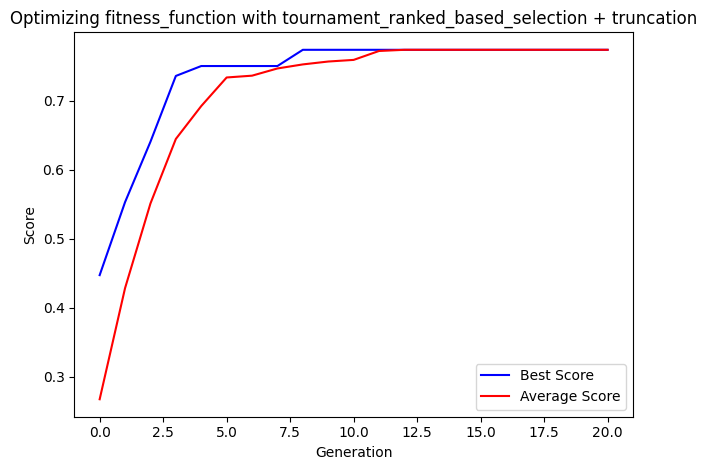

Generation: 20 with tournament_ranked_based_selection and truncation
1. Path = [0, 2, 4, 5, 4, 1, 1, 2, 4, 2], Score = 0.7739
2. Path = [0, 2, 4, 6, 4, 1, 1, 2, 4, 2], Score = 0.7739
3. Path = [0, 2, 4, 5, 4, 1, 1, 2, 4, 2], Score = 0.7739
4. Path = [0, 2, 4, 5, 4, 1, 1, 2, 4, 2], Score = 0.7739
5. Path = [0, 2, 4, 5, 4, 1, 1, 2, 4, 2], Score = 0.7739
6. Path = [0, 2, 4, 5, 4, 1, 1, 2, 4, 2], Score = 0.7739
7. Path = [0, 2, 4, 6, 4, 1, 1, 2, 4, 2], Score = 0.7739
8. Path = [0, 2, 4, 5, 4, 1, 1, 2, 4, 2], Score = 0.7739
9. Path = [0, 2, 4, 5, 4, 1, 1, 2, 4, 2], Score = 0.7739
10. Path = [0, 2, 4, 5, 4, 1, 1, 2, 4, 2], Score = 0.7739


('tournament_ranked_based_selection + truncation',
 [0.4470588235294118,
  0.5529411764705883,
  0.6405228758169934,
  0.7359477124183007,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7503267973856209,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268],
 [0.26705882352941174,
  0.42823529411764705,
  0.5509803921568628,
  0.6445751633986928,
  0.6922875816993465,
  0.7337254901960784,
  0.7363398692810457,
  0.746797385620915,
  0.7526797385620915,
  0.7568627450980392,
  0.7592156862745097,
  0.7721568627450981,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268,
  0.7738562091503268])

In [373]:
genetic_algorithm_n_gens(persons, fitness_function=fitness_function, n_gens=20, parent_selection_function=tournament_ranked_based_selection,mutation_rate=0.5)